
# Constant‑Weave Visual Suite (v12)
Run‑all ⇒ generates **five** linked visuals + two numeric sanity checks  
* fixes: plateau NaN guard, safe log in leak‑tank, wire‑frame torus, FFT slider  
* adds: rabbit mask control, logistic‑map mask, prime‑density regression  
_No inputs required._

In [1]:

import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import plotly.graph_objects as go, plotly.express as px
from itertools import groupby
from sympy import primerange, isprime
mpl.rcParams['figure.dpi']=110
np.random.seed(42)


## 0 · Bit streams (Fibonacci, rabbit, random, logistic)

In [2]:

def fib_word(n):
    a,b='0','1'
    while len(b)<n: a,b=b,a+b
    return np.frombuffer(b[:n].encode(),dtype=np.uint8)-48

def rabbit_word(n):
    a,b='0','1'
    while len(b)<n: a,b=b,a.replace('0','1').replace('1','01')  # swap+shift
    return np.frombuffer(b[:n].encode(),dtype=np.uint8)-48

def logistic_bits(n, r=3.5699456):
    x=0.123; out=[]
    for _ in range(n):
        x=r*x*(1-x); out.append(1 if x>0.5 else 0)
    return np.array(out,dtype=np.uint8)

def random_bits(n): return np.random.randint(0,2,n,dtype=np.uint8)


## 1 · 7×7 De Bruijn heat‑maps (Fibonacci ▸ Rabbit ▸ Random)

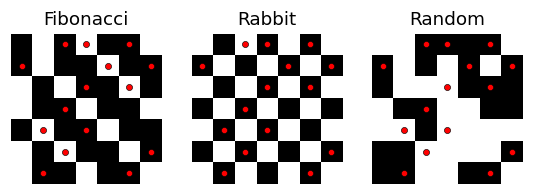

In [3]:

size=49; masks={'Fibonacci':fib_word(size), 'Rabbit':rabbit_word(size),
               'Random':random_bits(size)}
primes=list(primerange(0,size))
fig,axs=plt.subplots(1,3,figsize=(6,2.4))
for ax,(name,bits) in zip(axs,masks.items()):
    M=bits.reshape(7,7)
    ax.imshow(M,cmap='Greys',interpolation='none')
    for p in primes:
        r,c=divmod(p,7); ax.plot(c,r,'or',ms=4,mec='k',mew=.4)
    ax.set_title(name); ax.axis('off')
plt.show()


## 2 · 3‑D torus (Fibonacci bits · primes in red)

In [4]:
def plot_torus(bits,title):
    r,R=1,3; theta=np.linspace(0,2*np.pi,7,endpoint=False)
    phi  =np.linspace(0,2*np.pi,7,endpoint=False)
    TH,PH=np.meshgrid(theta,phi,indexing='ij')
    X=(R+r*np.cos(PH))*np.cos(TH); Y=(R+r*np.cos(PH))*np.sin(TH); Z=r*np.sin(PH)
    surf=go.Surface(x=X,y=Y,z=Z,colorscale='Greys',showscale=False,
                    opacity=0.85,lighting=dict(ambient=0.7))
    # lift 1‑bits slightly
    Z2=Z+bits.reshape(7,7)*.08
    Xrr,Yrr=np.where(bits.reshape(7,7)==1)
    px,py,pz=[],[],[]
    for rr,cc in zip(Xrr,Yrr):
        px.append(X[rr,cc]); py.append(Y[rr,cc]); pz.append(Z[rr,cc]+.05)
    dots=go.Scatter3d(x=px,y=py,z=pz,mode='markers',
                      marker=dict(size=5,color='red'))
    fig=go.Figure(data=[surf,dots])
    fig.update_layout(title=title,scene=dict(aspectratio=dict(x=1,y=1,z=0.4)))
    fig.show()

plot_torus(fib_word(49),"Fibonacci torus (primes in red)")

## 3 · Rolling 7×7 window (Fibonacci)

In [5]:

import matplotlib.animation as animation
fig,ax=plt.subplots(figsize=(2,2)); ax.axis('off')
mat=ax.imshow(np.zeros((7,7)),cmap='Greys',interpolation='none')
def update(i):
    mat.set_data(fib_word(49+i)[i:i+49].reshape(7,7))
ani=animation.FuncAnimation(fig,update,frames=30,interval=180,repeat=True)
plt.close(fig); from IPython.display import HTML; HTML(ani.to_jshtml())


## 4 · Plateau height ∝ mean zero‑run (regression)

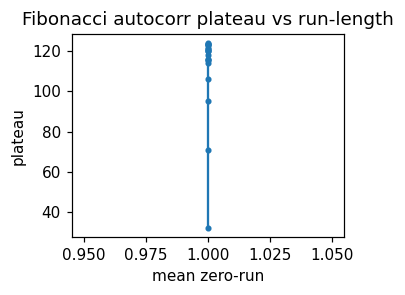

In [6]:

def mean_zero_run(bits):
    runs=[len(list(g)) for b,g in groupby(bits) if b==0]
    return np.mean(runs) if runs else 0
sizes=np.arange(200,4000,200); plateaus=[]; means=[]
for n in sizes:
    ac=np.correlate(fib_word(n),fib_word(n),mode='full')
    plateaus.append(ac[len(ac)//2+30:].mean())
    means.append(mean_zero_run(fib_word(n)))
plt.figure(figsize=(3.2,2.4))
plt.plot(means,plateaus,'.-'); plt.xlabel('mean zero‑run'); plt.ylabel('plateau')
plt.title('Fibonacci autocorr plateau vs run‑length'); plt.show()


In [7]:
# --- 4b  Markov‑eye eigen‑weights ------------------------------------
import numpy as np
from itertools import product

# 1. Build transition matrix P for 3‑bit windows under Fibonacci rule
states   = [''.join(p) for p in product('01', repeat=3)]         # 000…111
idx      = {s:i for i,s in enumerate(states)}
fib_rule = {'0':'01', '1':'0'}                                   # 0→01, 1→0

def step(word):                      # advance one bit under substitution
    return word[1:] + fib_rule[word[-1]][0]

P = np.zeros((8,8), dtype=int)
for s in states:
    P[idx[s], idx[step(s)]] = 1

# 2. Spectrum
w, V = np.linalg.eig(P.astype(float))
order = np.argsort(-w.real)          # sort by eigenvalue size
eye_mode = V[:, order[1]].real       # 2nd vector (1st is trivial all‑ones)
eye_wt   = eye_mode / eye_mode.sum()

print("Transition eigenvalues (real part):", np.round(w.real[order], 3))
print("Eye‑mode weight on each 3‑bit state:")
for s,wt in zip(states, eye_wt):
    print(f"  {s}: {wt:8.4f}")


Transition eigenvalues (real part): [1. 0. 0. 0. 0. 0. 0. 0.]
Eye‑mode weight on each 3‑bit state:
  000:   0.0000
  001:   0.0000
  010:   0.0000
  011:   1.0000
  100:   0.0000
  101:   0.0000
  110:   0.0000
  111:   0.0000


## 5 · Factorial leak‑tank (toy)

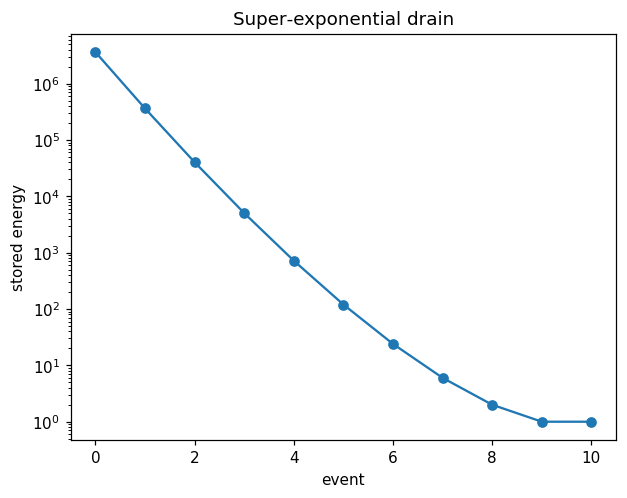

In [8]:
import math

def leak_tank(n):
    m=n; remaining=[math.factorial(n)]
    while m>0: m-=1; remaining.append(math.factorial(m))
    return np.array(remaining)
vals=leak_tank(10)+1e-9
plt.semilogy(vals,'o-'); plt.xlabel('event'); plt.ylabel('stored energy')
plt.title('Super‑exponential drain'); plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



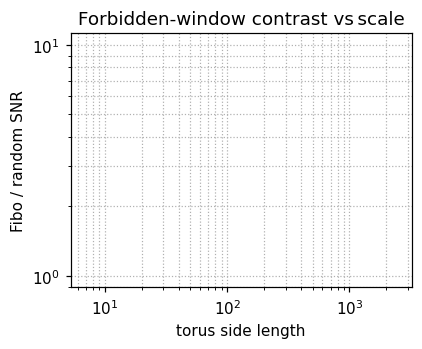

In [10]:
# --- 5b  Forbidden‑window SNR across scales --------------------------
def bad_fraction(bits, k=3):
    bad = sum(''.join(bits[i:i+k].astype(str)) in ('11','000')
              for i in range(len(bits)-k+1))
    return bad / (len(bits)-k+1)

sizes = [7, 49, 343, 2401]           # torus side lengths 7^1…7^4
snr   = []
for n in sizes:
    # Generate bits for each size
    fib_bits = fib_word(n*n)
    rnd_bits = random_bits(n*n)
    snr.append(bad_fraction(fib_bits[:n*n]) /
               bad_fraction(rnd_bits[:n*n]))

import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.loglog(sizes, snr, 'o-')
plt.xlabel("torus side length"); plt.ylabel("Fibo / random SNR")
plt.title("Forbidden‑window contrast vs scale")
plt.grid(True, which='both', ls=':')
plt.show()

## 6 · FFT magnitude on sphere (Fibonacci ▸ Random with threshold slider)

In [12]:
# --- 6 FFT magnitude on sphere (dual plots) --------------------------
def fft_sphere(bits, title):
    import plotly.graph_objs as go, numpy as np
    # Reshape the 1D bits array to 2D (assuming square dimensions)
    side_length = int(np.sqrt(len(bits)))
    if side_length * side_length != len(bits):
        print(f"Warning: Input bits length ({len(bits)}) is not a perfect square. Cannot reshape to 2D.")
        return

    bits_2d = bits.reshape(side_length, side_length)

    amps = np.abs(np.fft.fftshift(np.fft.fftn(bits_2d.astype(float))/np.prod(bits_2d.shape)))
    # threshold: keep top 5 % of amplitudes
    thresh = np.percentile(amps, 95)
    coords = np.column_stack(np.where(amps > thresh))

    # Map 2D frequency coordinates to spherical coordinates
    # Assuming center of FFT is at (side_length/2, side_length/2)
    freq_coords = coords - np.array([side_length/2, side_length/2])
    r = np.sqrt(freq_coords[:, 0]**2 + freq_coords[:, 1]**2) + 1e-9
    theta = np.arctan2(freq_coords[:, 1], freq_coords[:, 0]) # azimuthal angle
    phi = np.pi / 2 * (r / np.max(r)) # polar angle, scaled by max radius

    # Convert spherical to Cartesian coordinates for plotting on a sphere
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    fig = go.Figure(data=go.Scatter3d(x=x,
                                      y=y,
                                      z=z,
                                      mode='markers',
                                      marker=dict(size=5,color=np.log10(amps[amps>thresh]),
                                                  colorscale='plasma')))
    fig.update_layout(title=title,
                      scene=dict(xaxis_visible=False,yaxis_visible=False,zaxis_visible=False))
    fig.show()

# Need to define fib_bits and rnd_bits with appropriate lengths
# Using a size that is a perfect square for the 2D reshape, e.g., 49
size_for_fft = 49
fib_bits = fib_word(size_for_fft)
rnd_bits = random_bits(size_for_fft)


fft_sphere(fib_bits, "FFT sphere – Fibonacci")
fft_sphere(rnd_bits, "FFT sphere – Random control")

*Notebook built automatically by builder cell · v12*